In [6]:
pip install opencv-python


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 39.5/39.5 MB 414.4 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 39.5/39.5 MB 1.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import cv2
print(cv2.__version__)


4.11.0


In [2]:
import os
import random
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# store the dataset in dataframe

In [3]:
#get img_id & img_path & category name and id

data_path = "UECFOOD100"

data_list = []

category_file_path = os.path.join(data_path, "category.txt")
category_df = pd.read_csv(category_file_path, sep='\t', index_col='id')

if not category_df.empty:
    # loop through each folder
    for folder_id_str in os.listdir(data_path):
        try:
            folder_id = int(folder_id_str)
            folder_path = os.path.join(data_path, folder_id_str)
            if os.path.isdir(folder_path):
                # loop through imgs in each folder
                img_folder_path = folder_path
                for img_filename in os.listdir(img_folder_path):
                    if img_filename.endswith(".jpg"):

                        img_id = int(os.path.splitext(img_filename)[0])

                        img_path = os.path.join(img_folder_path, img_filename)#get img path

                        if folder_id in category_df.index:
                            category = category_df.loc[folder_id, 'name']
                            category_id = folder_id

                            data_list.append({
                                "img_id": img_id,
                                "img_path": img_path,
                                "category": category,
                                "category_id": category_id
                            })
        except ValueError:
            print(f"skip other folders: {folder_id_str}")

    data_df = pd.DataFrame(data_list)
    csv_output_path = "data_info.csv"
    data_df.to_csv(csv_output_path, index=False)


skip other folders: category.txt
skip other folders: category_ja_euc.txt
skip other folders: category_ja_sjis.txt
skip other folders: category_ja_utf8.txt
skip other folders: multiple_food.txt
skip other folders: README.txt


In [4]:
data_path = "UECFOOD100"

# Load the existing CSV with image data
csv_path = "data_info.csv"
data_df = pd.read_csv(csv_path)
# Loop through each folder in UEFOOD100
for folder_id_str in os.listdir(data_path):
    try:
        folder_id = int(folder_id_str)
        folder_path = os.path.join(data_path, folder_id_str)

        if os.path.isdir(folder_path):
            # Specify the path for the bounding box file (bb_info.txt)
            bb_info_file_path = os.path.join(folder_path, "bb_info.txt")

            if os.path.exists(bb_info_file_path):
                try:
                    # Read the bounding box data from bb_info.txt
                    bb_info_df = pd.read_csv(bb_info_file_path, sep=' ', index_col=0, header=0, names=["x1", "y1", "x2", "y2"])

                    # Loop through rows in bb_info_df to assign bounding box coordinates
                    for img_id, bbox_info in bb_info_df.iterrows():
                        img_id = int(img_id)

                        # Create the correct image path pattern
                        pattern = f'UECFOOD100\\{folder_id}\\{img_id}.jpg'

                        # Find the matching rows in data_df based on img_path
                        matching_rows = data_df[data_df['img_path'] == pattern]

                        # Update the data_df with bounding box coordinates
                        data_df.loc[matching_rows.index, ["x1", "y1", "x2", "y2"]] = [bbox_info["x1"], bbox_info["y1"], bbox_info["x2"], bbox_info["y2"]]

                except pd.errors.EmptyDataError:
                    print(f"No data found in {bb_info_file_path}")
            else:
                print(f"bb_info.txt file not found in {folder_path}")

    except ValueError:
        print(f"Skipping invalid folder: {folder_id_str}")

# Save the updated data_df with bounding boxes
data_df.to_csv(csv_path, index=False)

Skipping invalid folder: category.txt
Skipping invalid folder: category_ja_euc.txt
Skipping invalid folder: category_ja_sjis.txt
Skipping invalid folder: category_ja_utf8.txt
Skipping invalid folder: multiple_food.txt
Skipping invalid folder: README.txt


In [5]:
data=pd.read_csv("data_info.csv")
data['category_id']=data['category_id']-1
data.head()

img_id                img_path category  category_id    x1     y1     x2  \
0       1      UECFOOD100\1\1.jpg     rice            0   0.0  143.0  370.0   
1      10     UECFOOD100\1\10.jpg     rice            0  71.0   16.0  478.0   
2   10572  UECFOOD100\1\10572.jpg     rice            0   0.0   49.0  360.0   
3   10586  UECFOOD100\1\10586.jpg     rice            0  19.0   69.0  355.0   
4   10617  UECFOOD100\1\10617.jpg     rice            0   0.0    4.0   91.0   

      y2  
0  486.0  
1  328.0  
2  420.0  
3  372.0  
4  246.0

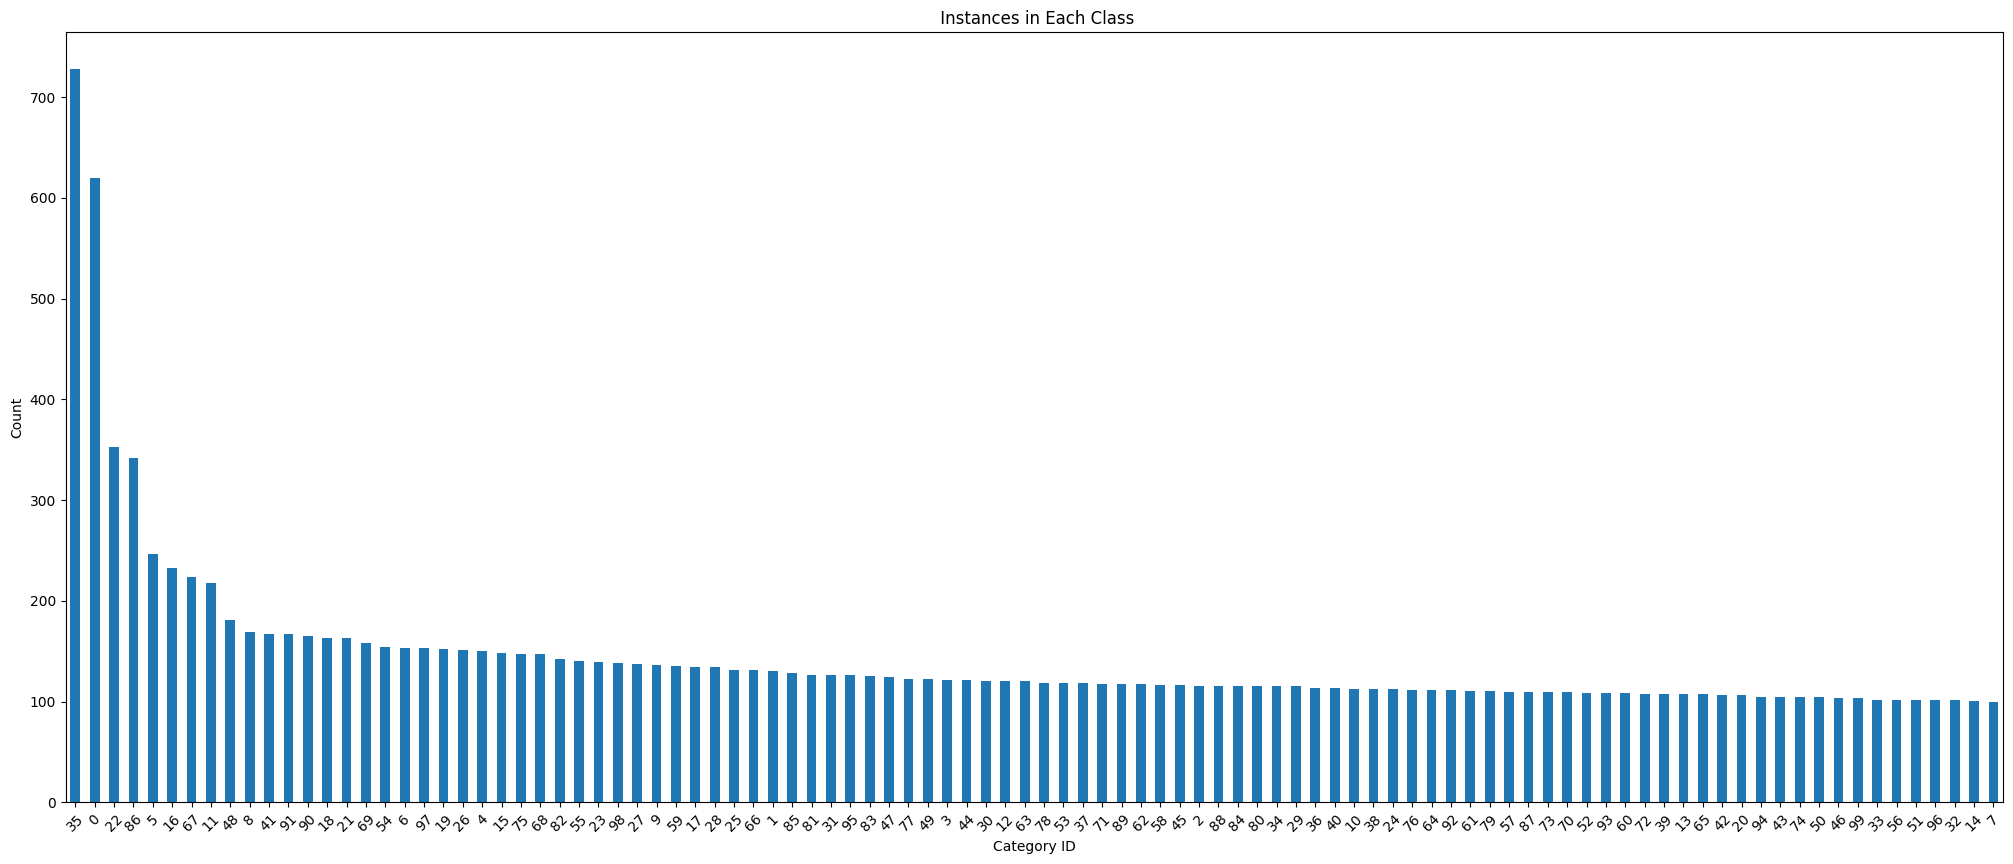

In [6]:
category_counts = data['category_id'].value_counts()
plt.figure(figsize=(25, 10))
category_counts.plot(kind='bar')
plt.title(' Instances in Each Class')
plt.xlabel('Category ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [7]:
len(data)

14361

In [8]:
data.to_csv('balanced.csv', index=False)

In [9]:
df = pd.read_csv('balanced.csv')

merged_df = df.groupby('img_id', as_index=False).agg({
    'img_path': 'first',
    'category': lambda x: ','.join(x),
    'category_id': lambda x: ','.join(map(str, x)),
    'x1': lambda x: ','.join(map(str, x)),
    'y1': lambda x: ','.join(map(str, x)),
    'x2': lambda x: ','.join(map(str, x)),
    'y2': lambda x: ','.join(map(str, x))
})

merged_df.to_csv('multiple_data.csv', index=False)


In [10]:
df = pd.read_csv("multiple_data.csv")
df.head(10)

img_id             img_path          category category_id         x1  \
0       1   UECFOOD100\1\1.jpg       rice,jiaozi        0,41  0.0,363.0   
1       2   UECFOOD100\1\2.jpg              rice           0       20.0   
2       3   UECFOOD100\1\3.jpg              rice           0        2.0   
3       4   UECFOOD100\1\4.jpg              rice           0        0.0   
4       5   UECFOOD100\1\5.jpg              rice           0        8.0   
5       6   UECFOOD100\1\6.jpg              rice           0        0.0   
6       7   UECFOOD100\1\7.jpg              rice           0        0.0   
7       8   UECFOOD100\1\8.jpg              rice           0       80.0   
8       9   UECFOOD100\1\9.jpg  rice,beef noodle        0,23  2.0,278.0   
9      10  UECFOOD100\1\10.jpg              rice           0       71.0   

           y1           x2           y2  
0  143.0,91.0  370.0,800.0  486.0,560.0  
1       208.0        582.0        559.0  
2       110.0        243.0        410.0  
3       237.0        286.0        536.0  
4        28.0        761.0        585.0  
5        38.0        369.0        310.0  
6       162.0        383.0        450.0  
7        31.0        776.0        454.0  
8  226.0,76.0  270.0,798.0  470.0,509.0  
9        16.0        478.0        328.0

# split dataset

In [11]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_csv_path = "train_data.csv"
val_csv_path = "val_data.csv"
test_csv_path = "test_data.csv"

train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
train_df.head()

img_id                img_path             category category_id     x1  \
5131    5178  UECFOOD100\51\5178.jpg  sweet and sour pork          50   63.0   
7088    7452  UECFOOD100\70\7452.jpg            cold tofu          69    9.0   
2162    2180  UECFOOD100\22\2180.jpg          soba noodle          21   51.0   
3788    3806  UECFOOD100\39\3806.jpg                 oden          38  150.0   
8769    9133  UECFOOD100\27\9133.jpg            spaghetti          26   15.0   

         y1     x2     y2  
5131  114.0  390.0  259.0  
7088   31.0  126.0  138.0  
2162   25.0  170.0  128.0  
3788    0.0  420.0  117.0  
8769  109.0  303.0  390.0

In [ ]:
# Ambil 16 index acak dari dataframe balanced
random_images = df.sample(n=16).index


In [18]:
balanced = pd.read_csv("balanced.csv")

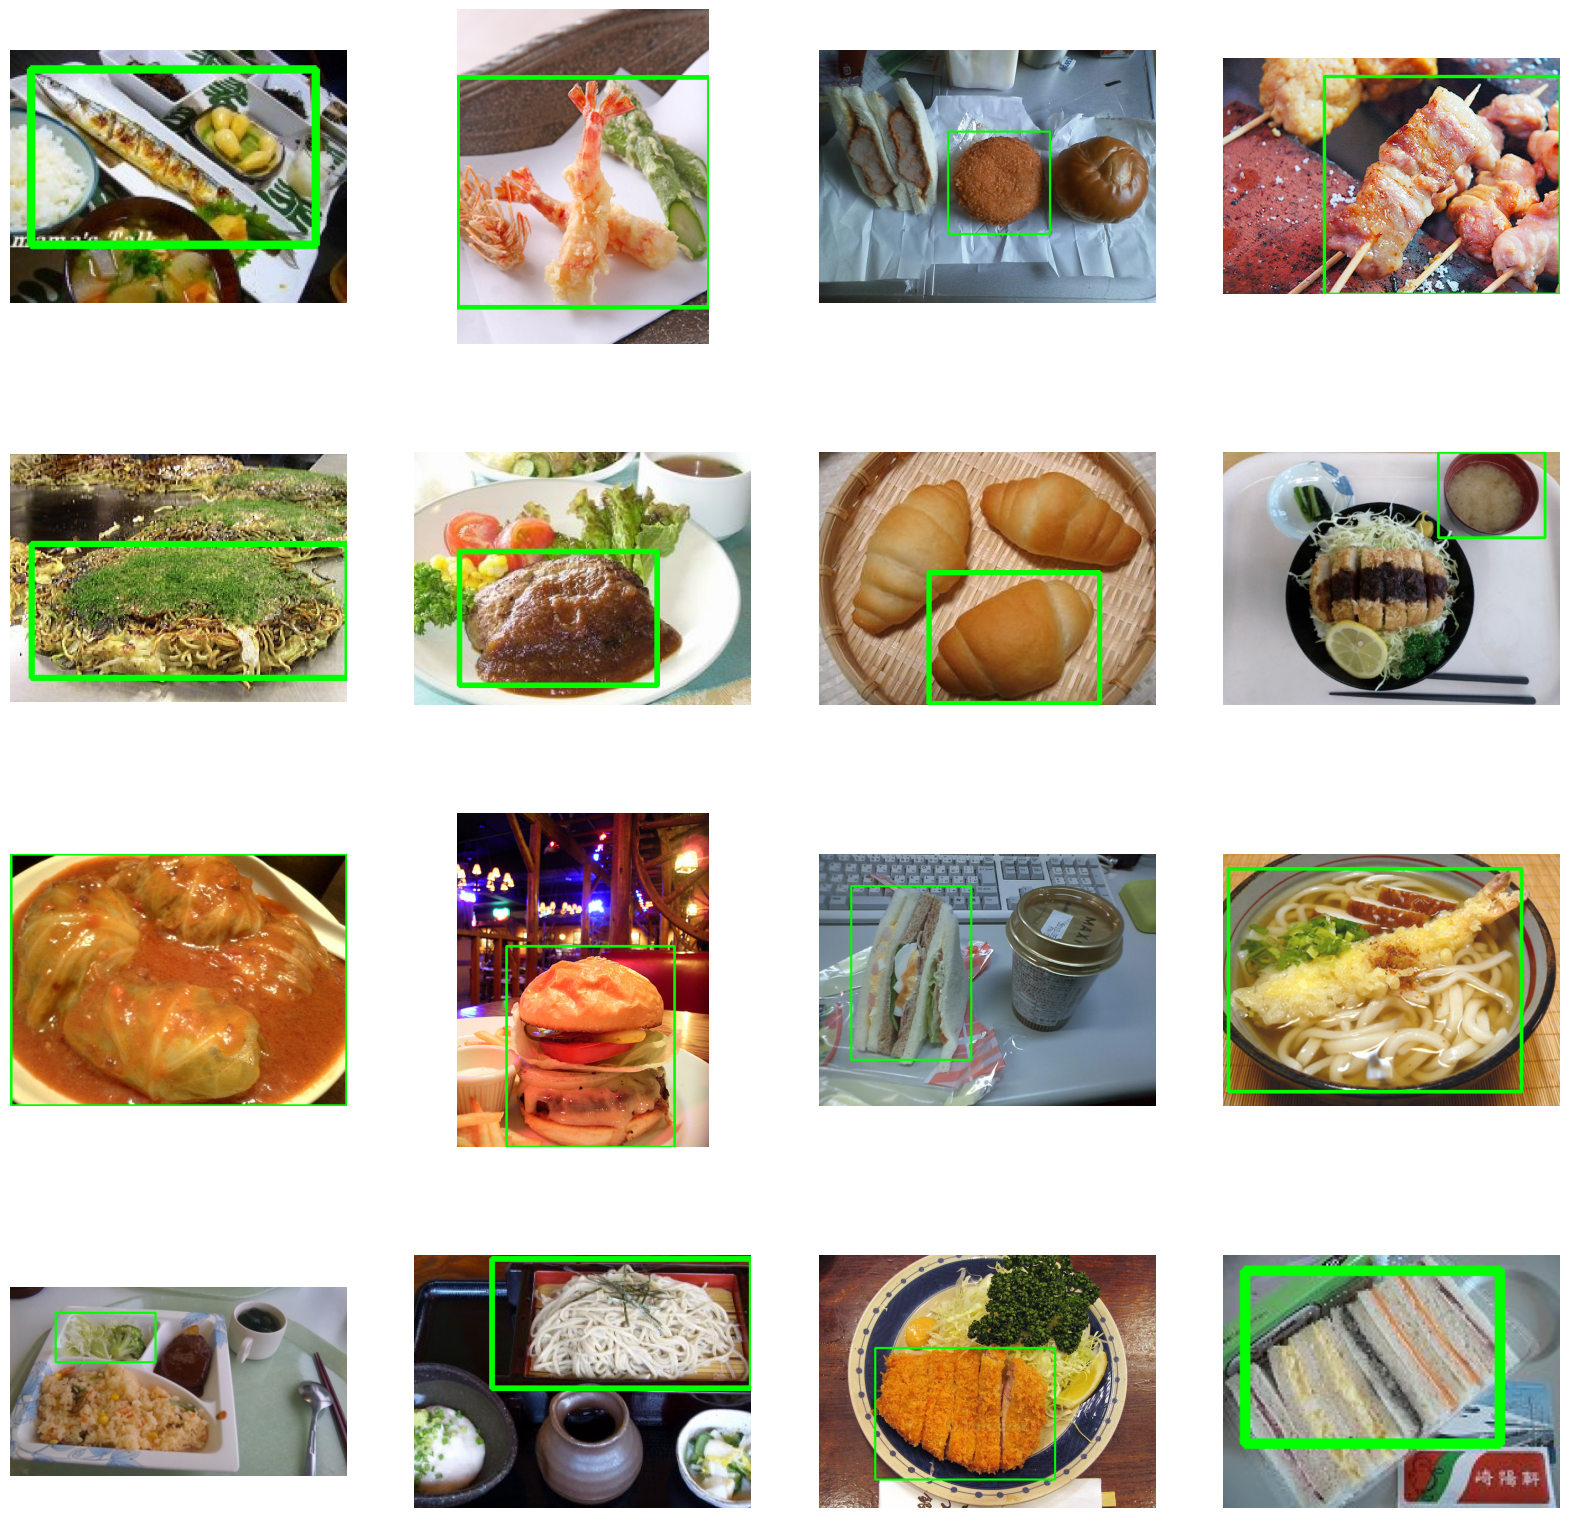

In [19]:
import numpy as np

# Set up the plot with 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, idx in enumerate(random_images):
    row = i // 4
    col = i % 4

    img_id = balanced.loc[idx, "img_id"]
    img_path = balanced.loc[idx, "img_path"]
    category_id = int(balanced.loc[idx, "category_id"])

    # Check if bounding box values are NaN and skip if they are
    if balanced.loc[idx, ["x1", "y1", "x2", "y2"]].isnull().any():
        continue  # Skip this image if any bounding box value is NaN

    x1, y1, x2, y2 = int(balanced.loc[idx, "x1"]), int(balanced.loc[idx, "y1"]), int(balanced.loc[idx, "x2"]), int(balanced.loc[idx, "y2"])

    # Load the image
    img = cv2.imread(img_path)

    # Draw bounding box on the image
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)

    # Display the image with bounding box
    axs[row, col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [20]:
print(f"Loading image from: {img_path}")


Loading image from: UECFOOD100\19\1836.jpg


# create new paths in yolo dataset format

In [21]:
train_images = "new_data/train/images"
train_labels = "new_data/train/labels"

val_images = "new_data/val/images"
val_labels = "new_data/val/labels"

test_images = "new_data/test/images"
test_labels = "new_data/test/labels"

# train path

In [22]:
train_csv = pd.read_csv("train_data.csv")

output_folder_path = "new_data/train"
os.makedirs(output_folder_path, exist_ok=True)

images_folder_path = os.path.join(output_folder_path, "images")
labels_folder_path = os.path.join(output_folder_path, "labels")
os.makedirs(images_folder_path, exist_ok=True)
os.makedirs(labels_folder_path, exist_ok=True)

def pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h):
    x_center = (x1 + x2) / (2 * image_w)
    y_center = (y1 + y2) / (2 * image_h)
    width = (x2 - x1) / image_w
    height = (y2 - y1) / image_h
    return x_center, y_center, width, height

# Iterate over each row in the DataFrame
for _, row in data_df.iterrows():
    img_id = row["img_id"]
    img_path = row["img_path"]
    categories = row["category"].split(",")
    category_ids = [int(x) for x in str(row["category_id"]).split(",")]
    x1_values = [float(x) for x in str(row["x1"]).split(",")]
    y1_values = [float(x) for x in str(row["y1"]).split(",")]
    x2_values = [float(x) for x in str(row["x2"]).split(",")]
    y2_values = [float(x) for x in str(row["y2"]).split(",")]

    # Read and resize image
    img = cv2.imread(img_path)
    resized_img = cv2.resize(img, (640, 640))
    image_h, image_w, _ = resized_img.shape

    # Create a list to store records for each image
    image_records = []

    # Append records to the list
    for i in range(len(categories)):
        category_id = category_ids[i]
        x1, y1, x2, y2 = x1_values[i], y1_values[i], x2_values[i], y2_values[i]
        x_center, y_center, width, height = pascal_voc_to_yolo(x1, y1, x2, y2, img.shape[1], img.shape[0])
        record = f"{category_id} {x_center} {y_center} {width} {height}"
        image_records.append(record)

    # Write records to label text file
    label_filename = f"{img_id}.txt"
    label_destination_path = os.path.join(labels_folder_path, label_filename)
    with open(label_destination_path, "w") as label_file:
        for record in image_records:
            label_file.write(f"{record}\n")

    # Copy and resize images
    img_filename = f"{img_id}.jpg"
    img_destination_path = os.path.join(images_folder_path, img_filename)
    cv2.imwrite(img_destination_path, resized_img)


# test path


In [23]:
test_csv = pd.read_csv("test_data.csv")

output_folder_path = "new_data/test"
os.makedirs(output_folder_path, exist_ok=True)

images_folder_path = os.path.join(output_folder_path, "images")
labels_folder_path = os.path.join(output_folder_path, "labels")
os.makedirs(images_folder_path, exist_ok=True)
os.makedirs(labels_folder_path, exist_ok=True)

def pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h):
    x_center = (x1 + x2) / (2 * image_w)
    y_center = (y1 + y2) / (2 * image_h)
    width = (x2 - x1) / image_w
    height = (y2 - y1) / image_h
    return x_center, y_center, width, height

# Iterate over each row in the DataFrame
for _, row in data_df.iterrows():
    img_id = row["img_id"]
    img_path = row["img_path"]
    categories = row["category"].split(",")
    category_ids = [int(x) for x in str(row["category_id"]).split(",")]
    x1_values = [float(x) for x in str(row["x1"]).split(",")]
    y1_values = [float(x) for x in str(row["y1"]).split(",")]
    x2_values = [float(x) for x in str(row["x2"]).split(",")]
    y2_values = [float(x) for x in str(row["y2"]).split(",")]

    # Read and resize image
    img = cv2.imread(img_path)
    resized_img = cv2.resize(img, (640, 640))
    image_h, image_w, _ = resized_img.shape

    # Create a list to store records for each image
    image_records = []

    # Append records to the list
    for i in range(len(categories)):
        category_id = category_ids[i]
        x1, y1, x2, y2 = x1_values[i], y1_values[i], x2_values[i], y2_values[i]
        x_center, y_center, width, height = pascal_voc_to_yolo(x1, y1, x2, y2, img.shape[1], img.shape[0])
        record = f"{category_id} {x_center} {y_center} {width} {height}"
        image_records.append(record)

    # Write records to label text file
    label_filename = f"{img_id}.txt"
    label_destination_path = os.path.join(labels_folder_path, label_filename)
    with open(label_destination_path, "w") as label_file:
        for record in image_records:
            label_file.write(f"{record}\n")

    # Copy and resize images
    img_filename = f"{img_id}.jpg"
    img_destination_path = os.path.join(images_folder_path, img_filename)
    cv2.imwrite(img_destination_path, resized_img)


# val path

In [24]:
val_csv = pd.read_csv("val_data.csv")

output_folder_path = "new_data/val"
os.makedirs(output_folder_path, exist_ok=True)

images_folder_path = os.path.join(output_folder_path, "images")
labels_folder_path = os.path.join(output_folder_path, "labels")
os.makedirs(images_folder_path, exist_ok=True)
os.makedirs(labels_folder_path, exist_ok=True)

def pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h):
    x_center = (x1 + x2) / (2 * image_w)
    y_center = (y1 + y2) / (2 * image_h)
    width = (x2 - x1) / image_w
    height = (y2 - y1) / image_h
    return x_center, y_center, width, height

# Iterate over each row in the DataFrame
for _, row in data_df.iterrows():
    img_id = row["img_id"]
    img_path = row["img_path"]
    categories = row["category"].split(",")
    category_ids = [int(x) for x in str(row["category_id"]).split(",")]
    x1_values = [float(x) for x in str(row["x1"]).split(",")]
    y1_values = [float(x) for x in str(row["y1"]).split(",")]
    x2_values = [float(x) for x in str(row["x2"]).split(",")]
    y2_values = [float(x) for x in str(row["y2"]).split(",")]

    # Read and resize image
    img = cv2.imread(img_path)
    resized_img = cv2.resize(img, (640, 640))
    image_h, image_w, _ = resized_img.shape

    # Create a list to store records for each image
    image_records = []

    # Append records to the list
    for i in range(len(categories)):
        category_id = category_ids[i]
        x1, y1, x2, y2 = x1_values[i], y1_values[i], x2_values[i], y2_values[i]
        x_center, y_center, width, height = pascal_voc_to_yolo(x1, y1, x2, y2, img.shape[1], img.shape[0])
        record = f"{category_id} {x_center} {y_center} {width} {height}"
        image_records.append(record)

    # Write records to label text file
    label_filename = f"{img_id}.txt"
    label_destination_path = os.path.join(labels_folder_path, label_filename)
    with open(label_destination_path, "w") as label_file:
        for record in image_records:
            label_file.write(f"{record}\n")

    # Copy and resize images
    img_filename = f"{img_id}.jpg"
    img_destination_path = os.path.join(images_folder_path, img_filename)
    cv2.imwrite(img_destination_path, resized_img)


# train YOLO8 object detection model

In [25]:

! pip install ultralytics

   ---------------------------------------- 1.0/1.0 MB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 1.7/1.7 MB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 212.5/212.5 MB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 6.3/6.3 MB 2.6 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1
    Uninstalling torch-2.5.1:
      Successfully uninstalled torch-2.5.1



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from ultralytics import YOLO

In [27]:
import os
train_data = os.listdir(train_images)

train_image_file_paths = [os.path.join(train_images,i) for i in train_data if '.jpg' in i]
len(train_image_file_paths)

12740

In [28]:
val_data = os.listdir(val_images)

val_image_file_paths = [os.path.join(val_images,i) for i in val_data if '.jpg' in i]
len(val_image_file_paths)

12740

In [29]:
test_data = os.listdir(test_images)

test_image_file_paths = [os.path.join(test_images,i) for i in test_data if '.jpg' in i]
len(test_image_file_paths)

12740

In [ ]:
import os
import pandas as pd

# Paths (update these paths according to your data setup)
train_csv_path = "train_data.csv"   # Path to your train_data.csv
output_yaml_path = "data9.yaml"      # Output path for data.yaml

# Update these paths for train, val, and test directories
train_images_path = "new_data/train/images"
val_images_path = "new_data/valid/images"
test_images_path = "new_data/test/images"

# Read CSV to extract categories
data_df = pd.read_csv(train_csv_path)

# Extract unique classes
unique_categories = data_df['category'].str.split(",").explode().unique()
class_names = list(unique_categories)
num_classes = len(class_names)

# Ensure class names are valid (no spaces, special characters, etc.)
class_names = [name.strip().replace(" ", "_") for name in class_names]

# Write data.yaml content
data_yaml_content = f"""
train: {train_images_path}
val: {val_images_path}
test: {test_images_path}

nc: {num_classes}

names:
"""
for class_name in class_names:
    data_yaml_content += f"  - {class_name}\n"

# Save to file
with open(output_yaml_path, "w") as yaml_file:
    yaml_file.write(data_yaml_content)

print(f"`data.yaml` has been created at: {output_yaml_path}")
print("Class names:", class_names)
print("Number of classes:", num_classes)

`data.yaml` has been created at: data9.yaml
Class names: ['sweet_and_sour_pork', 'cold_tofu', 'soba_noodle', 'oden', 'spaghetti', 'hamburger', 'miso_soup', 'gratin', 'egg_roll', 'cabbage_roll', 'sushi', 'beef_noodle', 'simmered_pork', 'spaghetti_meat_sauce', 'beef_bowl', 'dried_fish', 'dipping_noodles', 'bibimbap', 'sukiyaki', 'grilled_eggplant', 'pizza_toast', 'stir-fried_beef_and_peppers', 'ramen_noodle', 'roast_chicken', 'vegetable_tempura', 'roll_bread', 'Japanese-style_pancake', 'sandwiches', 'udon_noodle', 'raisin_bread', 'sashimi', 'beef_steak', 'croquette', 'rice', 'potato_salad', 'nanbanzuke', 'potage', 'beef_curry', 'sauteed_vegetables', 'fried_fish', 'eels_on_rice', 'sashimi_bowl', 'omelet_with_fried_rice', 'fish-shaped_pancake_with_bean_jam', 'omelet', 'macaroni_salad', 'jiaozi', 'green_salad', 'fried_shrimp', 'ginger_pork_saute', 'boiled_fish', 'sirloin_cutlet', 'tensin_noodle', 'egg_sunny-side_up', 'salmon_meuniere', 'grilled_salmon', 'chinese_soup', 'toast', 'kinpira-sty

In [68]:
import torch
print(torch.__file__)

c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\__init__.py


In [69]:
pip show torch


Name: torchNote: you may need to restart the kernel to use updated packages.

Version: 2.5.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchaudio, torchvision, ultralytics, ultralytics-thop


In [1]:
import torch
print(torch.__version__)               # Harus 2.5.1+cu121
print(torch.cuda.is_available())       # ✅ Harus True
print(torch.cuda.device_count())       # ✅ Harus ≥ 1
print(torch.cuda.get_device_name(0))   # ✅ Harus "NVIDIA GeForce RTX 3050"


2.5.1+cu121
True
1
NVIDIA GeForce RTX 3050 Laptop GPU


In [18]:
import os
from ultralytics import YOLO

os.environ["MLFLOW_TRACKING_URI"] = "file:///C:/Users/ramad/runs/mlflow"  # Set the tracking URI to a valid directory

# Initialize YOLO model
model = YOLO('yolov8s.pt')

# Start training
model.train(
    data='dataset109.yaml',  # Path to your dataset YAML file
    epochs=10,               # Number of epochs
    imgsz=640,               # Image size
    seed=42,                 # Random seed for reproducibility
    save=True,               # Save checkpoints
    batch=8,                # Batch size
    half=False,              # Disable mixed precision if training on CPU
    augment=True,            # Enable augmentations
    device =0,
    workers=0,               # default 8 bisa terlalu berat
    cache=False,


)


New https://pypi.org/project/ultralytics/8.3.150 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset109.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train9, nbs=64, nms=False, opset=None, optimize

train: Scanning C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\train\labels.cache... 12740 images, 0 backgrounds, 63 corrupt: 100%|██████████| 12740/12740 [00:00<?, ?it/s]

train: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\train\images\10770.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3933]
train: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\train\images\10784.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4045]
train: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\train\images\10787.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5655]
train: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\train\images\10866.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2833]
train: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\train\images\10870.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates

val: Fast image access  (ping: 0.40.1 ms, read: 69.222.3 MB/s, size: 126.7 KB)


val: Scanning C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\val\labels.cache... 12740 images, 0 backgrounds, 63 corrupt: 100%|██████████| 12740/12740 [00:00<?, ?it/s]

val: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\val\images\10770.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3933]
val: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\val\images\10784.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4045]
val: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\val\images\10787.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5655]
val: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\val\images\10866.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2833]
val: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\val\images\10870.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1972]
val: 

Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=8.8e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train9
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.12G     0.9828      6.106      1.744          5        640: 100%|██████████| 1585/1585 [14:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [06:13<00:00,  2.12it/s]


                   all      12677      12677      0.196      0.202      0.117      0.081

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.19G      0.828      3.364      1.599          5        640: 100%|██████████| 1585/1585 [5:23:58<00:00, 12.26s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [06:22<00:00,  2.07it/s]


                   all      12677      12677       0.33      0.407      0.325       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.13G     0.8001      2.655      1.564          5        640: 100%|██████████| 1585/1585 [13:28<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [06:08<00:00,  2.15it/s]


                   all      12677      12677       0.46      0.498      0.468      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.19G     0.7692       2.26      1.532          5        640: 100%|██████████| 1585/1585 [13:21<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [05:59<00:00,  2.21it/s]


                   all      12677      12677      0.531      0.551      0.558      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.15G     0.7432      1.984      1.502          5        640: 100%|██████████| 1585/1585 [1:02:12<00:00,  2.36s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [05:59<00:00,  2.21it/s]


                   all      12677      12677        0.6      0.617      0.646      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.11G     0.7143      1.794      1.471          5        640: 100%|██████████| 1585/1585 [16:13<00:00,  1.63it/s]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [05:57<00:00,  2.22it/s]


                   all      12677      12677      0.653      0.664      0.707      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.09G     0.6957      1.636      1.448          5        640: 100%|██████████| 1585/1585 [13:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [05:47<00:00,  2.28it/s]


                   all      12677      12677       0.69      0.693      0.746      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       2.1G     0.6757      1.494      1.426          5        640: 100%|██████████| 1585/1585 [12:52<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [05:56<00:00,  2.23it/s]


                   all      12677      12677      0.717      0.722      0.782      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.17G     0.6557      1.395      1.411          5        640: 100%|██████████| 1585/1585 [12:58<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [05:53<00:00,  2.24it/s]


                   all      12677      12677      0.755      0.736       0.81       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.09G     0.6419      1.305      1.392          5        640: 100%|██████████| 1585/1585 [12:53<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [05:53<00:00,  2.24it/s]


                   all      12677      12677      0.769      0.761       0.83      0.649

10 epochs completed in 9.264 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 22.6MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 22.6MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics 8.3.149  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,167,767 parameters, 0 gradients, 28.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [09:32<00:00,  1.39it/s]


                   all      12677      12677      0.786      0.768      0.838      0.671
          eels on rice        138        138      0.978      0.601      0.827      0.638
                 pilaf        126        126      0.945      0.952      0.978      0.825
chicken-'n'-egg on rice        108        108      0.675      0.653      0.717      0.574
   pork cutlet on rice        118        118      0.718       0.54       0.71      0.649
            beef curry        140        140      0.853      0.757      0.859      0.702
                 sushi        210        210      0.746      0.876      0.902      0.776
          chicken rice        149        149      0.936      0.686      0.885       0.69
            fried rice         98         98      0.723      0.694      0.776      0.615
          tempura bowl        155        155      0.527      0.797      0.689      0.526
              bibimbap         95         95      0.843      0.792      0.874      0.702
                 toa

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001CBDE3B37D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001, 

In [8]:
from PIL import Image
import os

def validate_bboxes(label_path, image_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    img = Image.open(image_path)
    img_width, img_height = img.size
    for line in lines:
        cls, x_center, y_center, width, height = map(float, line.split())
        if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= width <= 1 and 0 <= height <= 1):
            print(f"Invalid bbox in {label_path}: {line}")

# Validate all labels
for label_file in os.listdir('C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/new_data/train/labels/'):
    validate_bboxes(f'C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/new_data/train/labels/{label_file}', f'C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/new_data/train/images/{label_file.replace(".txt", ".jpg")}')

Invalid bbox in C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/new_data/train/labels/10770.txt: 3 0.278125 0.8838951310861424 0.55625 1.3932584269662922

Invalid bbox in C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/new_data/train/labels/10784.txt: 9 0.278125 0.8745318352059925 0.55625 1.404494382022472

Invalid bbox in C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/new_data/train/labels/10787.txt: 79 0.225 0.8277153558052435 0.3625 1.5655430711610487

Invalid bbox in C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/new_data/train/labels/10866.txt: 24 0.375 0.6416666666666667 0.75 1.2833333333333334

Invalid bbox in C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/new_data/train/labels/10870.txt: 10 0.375 0.6680555555555555 0.75 1.1972222222222222

Invalid bbox in C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/new_data/trai

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



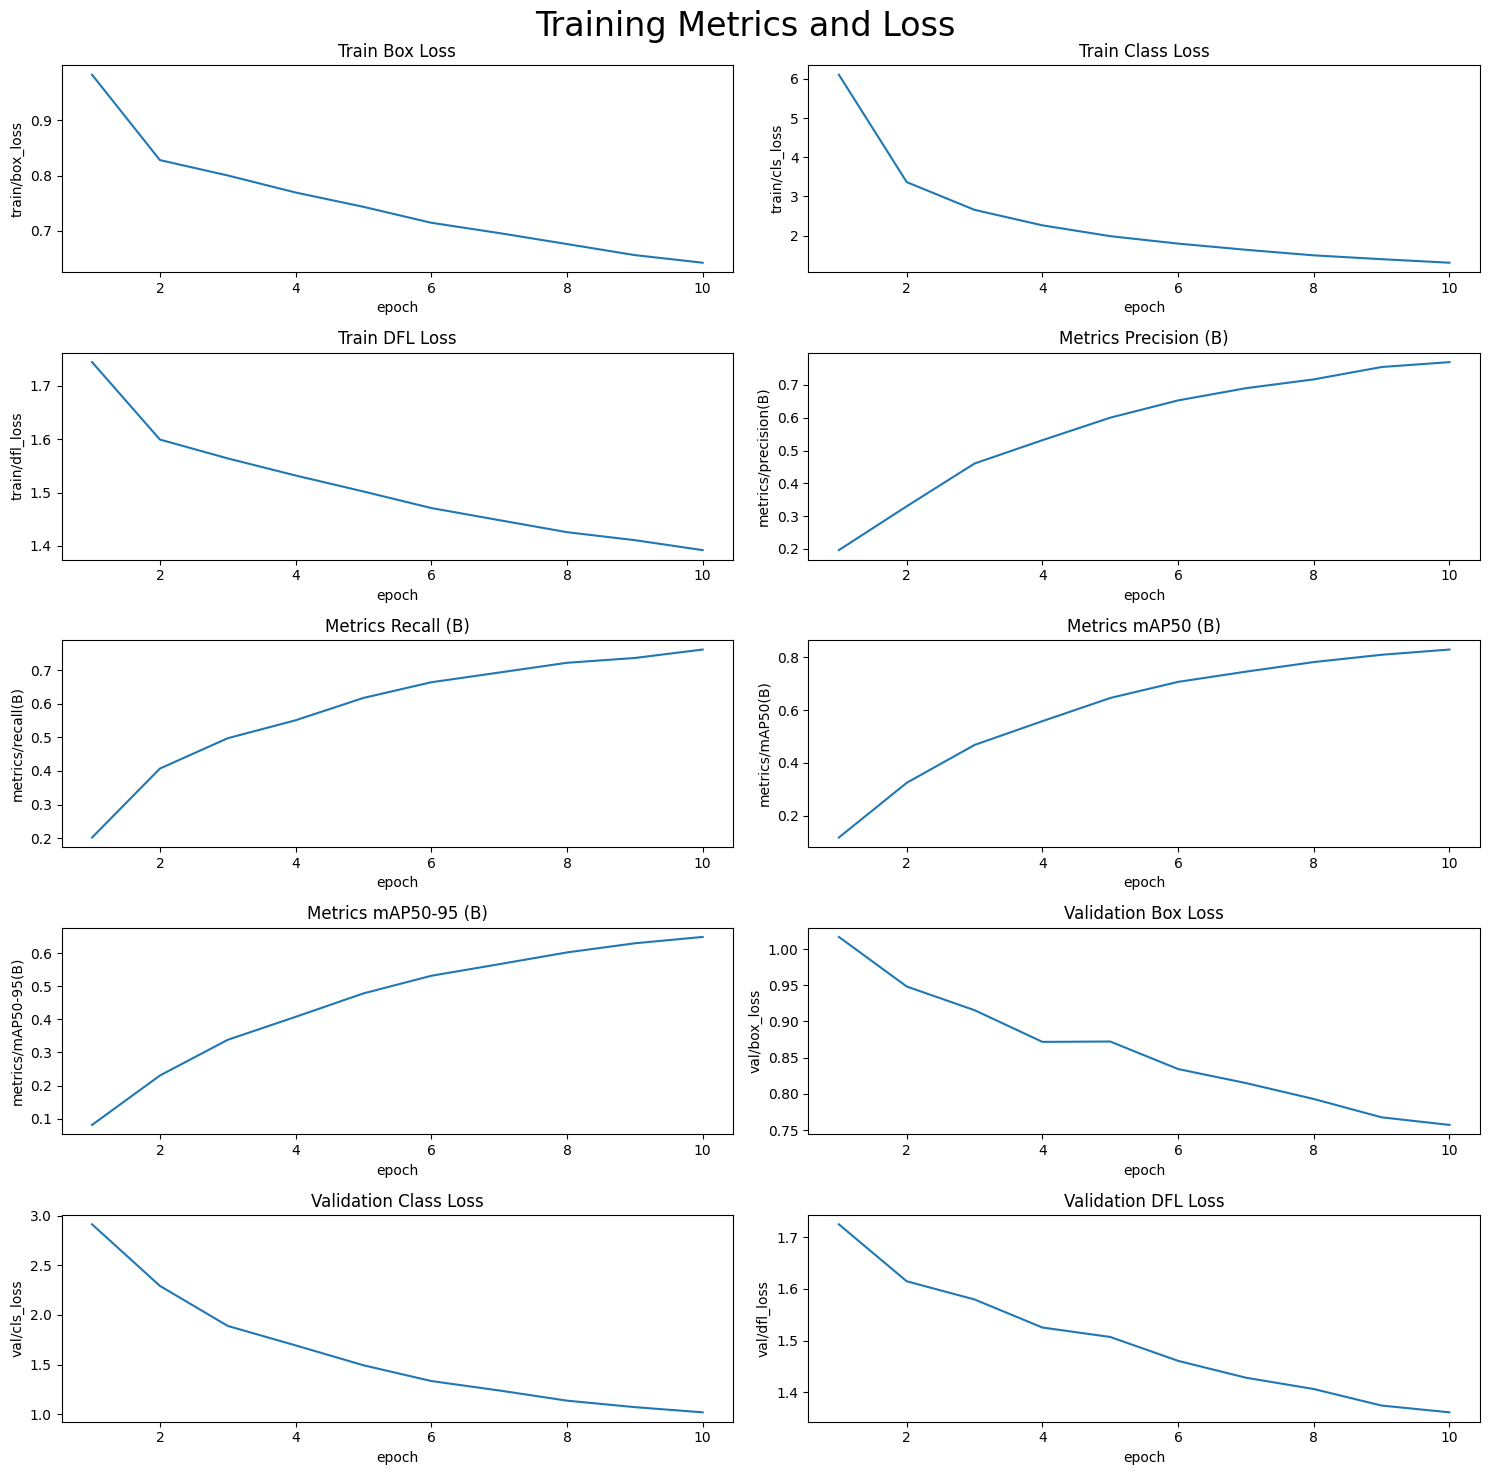

In [20]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/runs/detect/train9/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [22]:
%matplotlib inline
# Loading the best performing model

model = YOLO('C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/runs/detect/train9/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.149  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,167,767 parameters, 0 gradients, 28.7 GFLOPs
val: Fast image access  (ping: 1.00.2 ms, read: 118.842.5 MB/s, size: 107.6 KB)


val: Scanning C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\test\labels... 12740 images, 0 backgrounds, 63 corrupt: 100%|██████████| 12740/12740 [00:05<00:00, 2241.14it/s]

val: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\test\images\10770.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3933]
val: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\test\images\10784.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4045]
val: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\test\images\10787.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5655]
val: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\test\images\10866.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2833]
val: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\test\images\10870.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1972]


val: New cache created: C:\Users\ramad\OneDrive\Desktop\Dokumen\Kuliah\Semester 6\Machine Learning\new_data\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 793/793 [05:14<00:00,  2.52it/s]


                   all      12677      12677      0.769      0.761      0.818      0.662
          eels on rice        138        138      0.928      0.645      0.818      0.647
                 pilaf        126        126      0.945      0.821      0.924      0.808
chicken-'n'-egg on rice        108        108      0.655       0.63        0.7      0.551
   pork cutlet on rice        118        118      0.788      0.599      0.704      0.653
            beef curry        140        140      0.715      0.787      0.831      0.676
                 sushi        210        210      0.714      0.845      0.879       0.77
          chicken rice        149        149      0.927      0.683      0.848      0.681
            fried rice         98         98      0.798      0.612      0.731      0.563
          tempura bowl        155        155      0.541      0.777      0.682      0.518
              bibimbap         95         95      0.792      0.802      0.827      0.673
                 toa

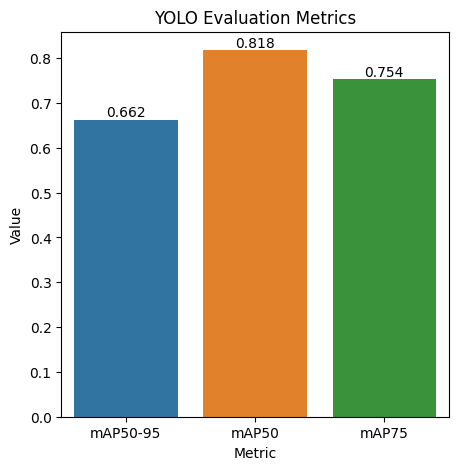

In [23]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(5, 5)
# fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

In [30]:
import os
import cv2
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO




0: 640x640 1 shrimp with chill source, 59.0ms
Speed: 14.6ms preprocess, 59.0ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 23.8ms
Speed: 7.3ms preprocess, 23.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pizza, 23.8ms
Speed: 7.0ms preprocess, 23.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 macaroni salad, 80.2ms
Speed: 8.6ms preprocess, 80.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 fried shrimp, 62.3ms
Speed: 5.6ms preprocess, 62.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 omelet with fried rice, 22.8ms
Speed: 3.4ms preprocess, 22.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 steamed egg hotchpotch, 1 macaroni salad, 22.4ms
Speed: 5.3ms preprocess, 22.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 sashimi bowl, 2

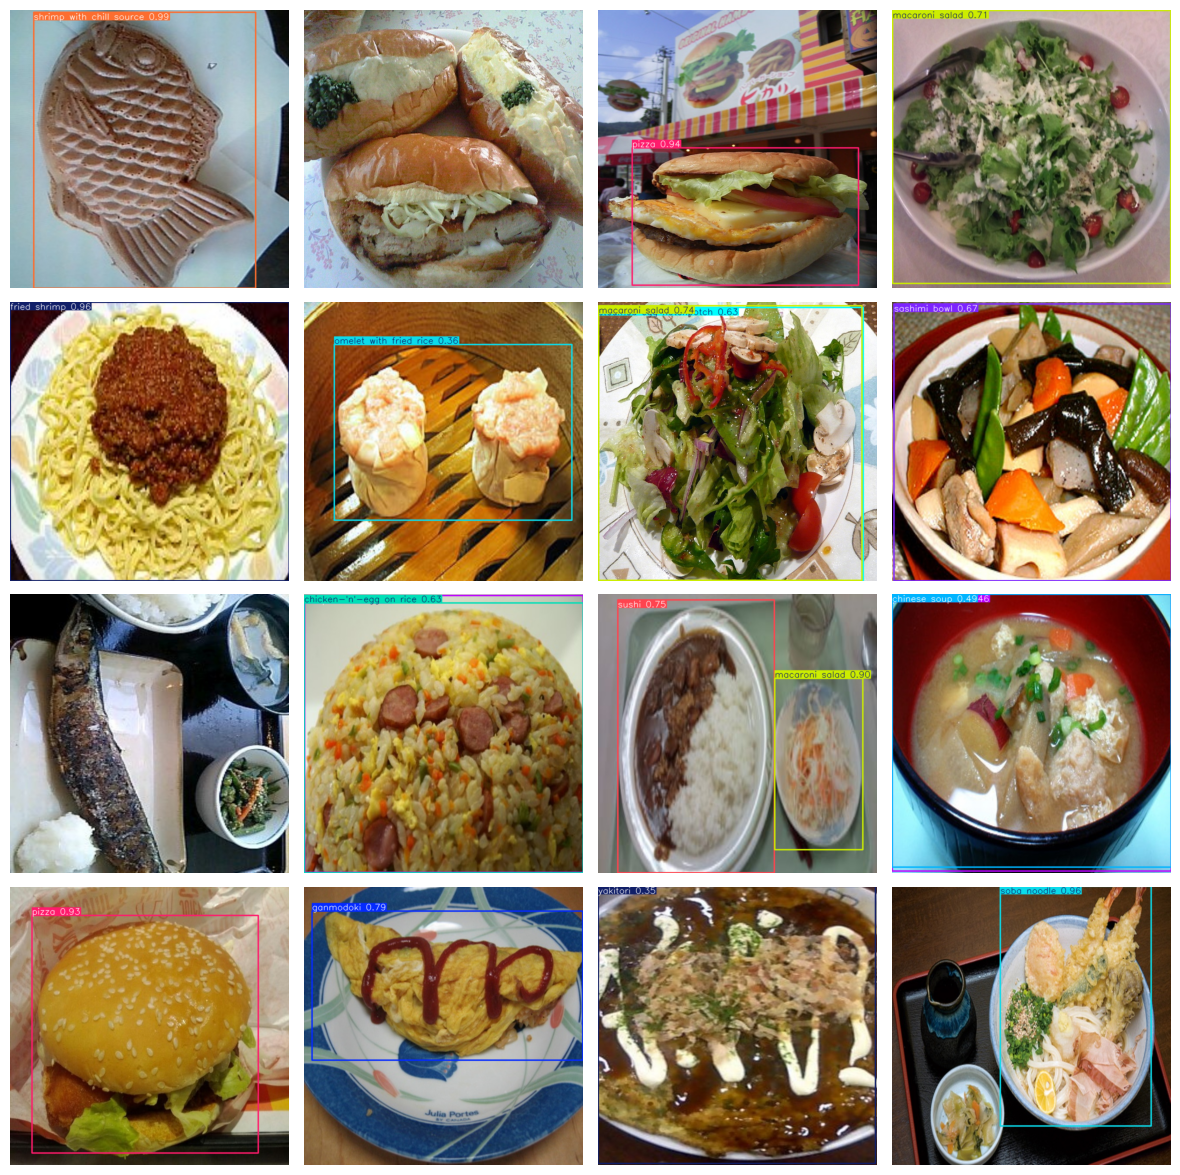

In [31]:
def img_detect(img_path):

    img = cv2.imread(img_path)
    detect_result = model(img)

    detect_img = detect_result[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img


custom_image_dir = "c:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/new_data/test/images"

image_files = os.listdir(custom_image_dir)

selected_images = random.sample(image_files, 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for i, img_file in enumerate(selected_images):

    row_idx = i // 4
    col_idx = i % 4

    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = img_detect(img_path)

    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)

!yolo task=detect mode=predict model= /kaggle/working/runs/detect/train3/weights/best.pt conf=0.5 source=/kaggle/working/new_data/test/images/6054.jpg

In [33]:
res=!yolo task=detect mode=predict model='C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/runs/detect/train9/weights/best.pt' conf=0.5 source=new_data/test/images/11694.jpg
res

['Traceback (most recent call last):',
 '  File "<frozen runpy>", line 198, in _run_module_as_main',
 '  File "<frozen runpy>", line 88, in _run_code',
 '  File "C:\\Users\\ramad\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\yolo.exe\\__main__.py", line 7, in <module>',
 '  File "c:\\Users\\ramad\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\ultralytics\\cfg\\__init__.py", line 905, in entrypoint',
 '    check_dict_alignment(full_args_dict, {a: ""})',
 '  File "c:\\Users\\ramad\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\ultralytics\\cfg\\__init__.py", line 498, in check_dict_alignment',
 '    raise SyntaxError(string + CLI_HELP_MSG) from e',
 "SyntaxError: '\x1b\x1b6/Machine\x1b' is not a valid YOLO argument. ",
 '',
 '    Arguments received: [\'yolo\', \'task=detect\', \'mode=predict\', "model=\'C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester", \'6/Machine\', "Learning/runs/detect/train9/weights/best.pt\'", \'conf=0.5\', \'so

In [36]:
model_path = "C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/runs/detect/train9/weights/best.pt"
image_path = "new_data/test/images/11694.jpg"

res = !yolo task=detect mode=predict model="{model_path}" conf=0.5 source="{image_path}"



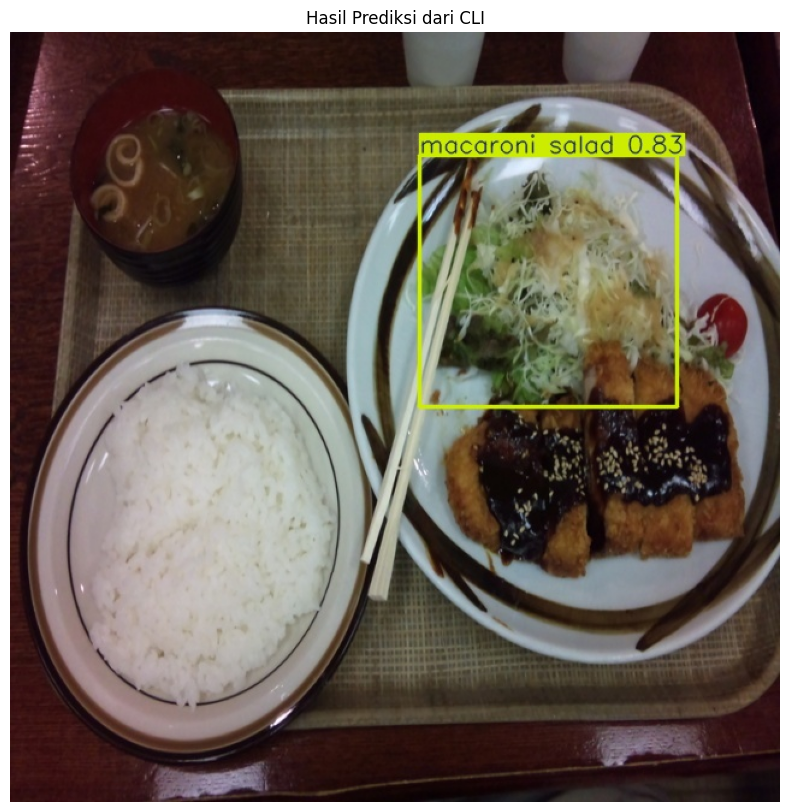

In [38]:
from PIL import Image
import matplotlib.pyplot as plt

# Gantilah dengan nama file hasil prediksi yang benar
img = Image.open("C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/runs/detect/predict/11694.jpg")

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Hasil Prediksi dari CLI")
plt.show()


In [39]:
model_path = "C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/runs/detect/train9/weights/best.pt"
image_path = "new_data/test/images/11695.jpg"

res = !yolo task=detect mode=predict model="{model_path}" conf=0.5 source="{image_path}"



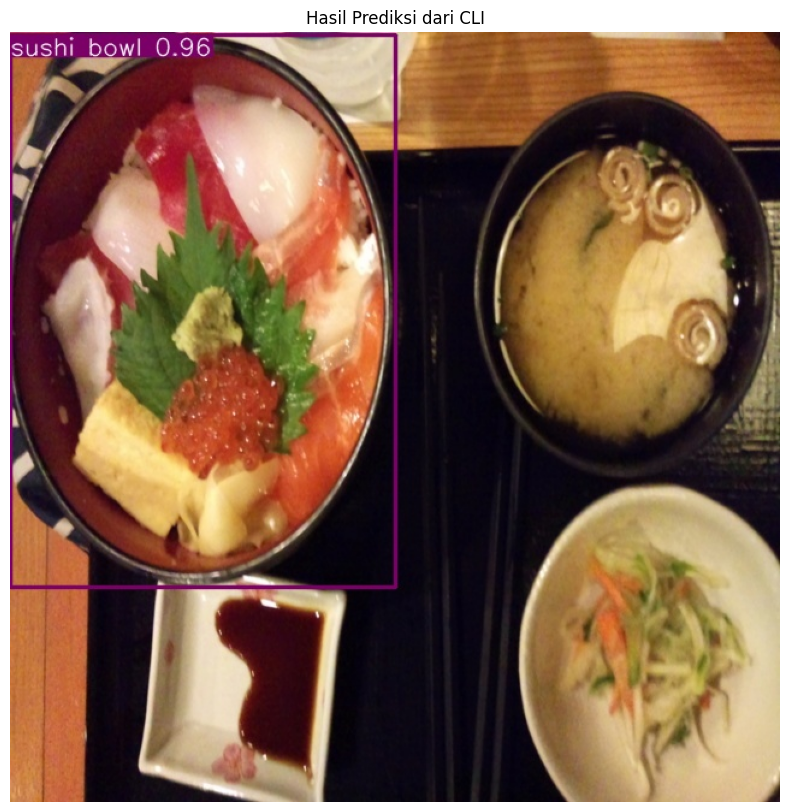

In [40]:
from PIL import Image
import matplotlib.pyplot as plt

# Gantilah dengan nama file hasil prediksi yang benar
img = Image.open("C:/Users/ramad/OneDrive/Desktop/Dokumen/Kuliah/Semester 6/Machine Learning/runs/detect/predict2/11695.jpg")

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Hasil Prediksi dari CLI")
plt.show()
